# Forecasting Run Expectancy Per Inning
**Goal:** Build a model that predicts expected runs scored *in an inning* for a batting team, using batter-level features (batter in batting rotation), contextual game features, and fielder defensive contribution (WAR). Run MC simulations of innings with simple logistic regression to sample for outcomes of at bats

**Notebook structure**
1. Config / params (easy-to-edit)
2. Data ingestion (pybaseball)
3. Feature engineering (batter-level + context + fielding WAR)
4. Create target: runs scored within an inning (team-inning)
5. Train/test splits
6. Markov state space model with logistic regression for transition probabilities
7. Evaluation: RMSE, MAE, coverage of CIs, calibration plots, example inning-level comparisons vs. observed
8. Notes on pitfalls, extensions, and alternatives


In [1]:
# Basic imports and configuration
import os
import numpy as np
import pandas as pd
from datetime import datetime
from joblib import Memory
import warnings

from pybaseball import statcast

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#Pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, batting_stats, batting_stats_range, statcast_pitcher
from pybaseball import pitching_stats, team_pitching, team_batting, schedule_and_record
    


# For saving / reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Make plotting look reasonable
plt.rcParams['figure.figsize'] = (10,5)


In [2]:
import warnings
warnings.filterwarnings("ignore")  # suppress all warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import logging
logging.getLogger().setLevel(logging.ERROR)


In [3]:
# Configurable parameters
START = '2024-03-01'   # start of data pull window 
END   = '2024-11-01'   # end of data pull window
MIN_PLATE_APPEARANCES = 50    # threshold for batter-season aggregation
TEST_SIZE = 0.2
GP_N_SAMPLES = 2000           # Monte Carlo samples for predictive distribution





In [4]:
# Caching directory
CACHE_DIR = "./cache"
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

memory = Memory(CACHE_DIR, verbose=1)

@memory.cache
def fetch_statcast(start_date, end_date):
    """Fetches Statcast with disk caching."""
    return statcast(start_date,end_date)

df_core = fetch_statcast(START, END)


In [5]:
#df_core number of rows and bytes
print(f"Statcast data from {START} to {END} has {df_core.shape[0]} rows and occupies {df_core.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB on disk.")

Statcast data from 2024-03-01 to 2024-11-01 has 760248 rows and occupies 1368.59 MB on disk.


In [6]:
NEEDED = [
    "game_pk", "game_date",
    "batter", "pitcher", "stand",
    "inning", "outs_when_up",
    "on_1b", "on_2b", "on_3b", "age_pit", "age_bat", "balls", "strikes", "pitch_number", #(pitch_number is per PA),
    "if_fielding_alignment", "of_fielding_alignment",
    "bat_score", "fld_score", 
    "events", "description"]

df = df_core[NEEDED].dropna(subset=["batter"]).copy()


In [7]:
df_core["description"].value_counts()

description
ball                       251022
foul                       135660
hit_into_play              134169
called_strike              123677
swinging_strike             81727
blocked_ball                15764
foul_tip                     7722
swinging_strike_blocked      4191
automatic_ball               2381
hit_by_pitch                 2201
foul_bunt                    1301
missed_bunt                   208
automatic_strike              153
pitchout                       55
bunt_foul_tip                  17
Name: count, dtype: int64

In [8]:

# Drop missing rows
df = df.dropna(subset=["batter", "pitcher", "events"])

#replace NaN in events with "PA_continues"
df["events"] = df["events"].fillna("PA_continues")

df.head()



,game_pk,game_date,batter,pitcher,stand,inning,outs_when_up,on_1b,on_2b,on_3b,...,age_bat,balls,strikes,pitch_number,if_fielding_alignment,of_fielding_alignment,bat_score,fld_score,events,description
162,775296,2024-10-30,657077,621111,L,9,2,<NA>,<NA>,<NA>,...,28,1,2,4,Infield shade,Standard,6,7,strikeout,swinging_strike_blocked
196,775296,2024-10-30,669224,621111,L,9,1,<NA>,<NA>,<NA>,...,25,3,2,7,Infield shade,Standard,6,7,strikeout,swinging_strike
280,775296,2024-10-30,683011,621111,R,9,0,<NA>,<NA>,<NA>,...,23,2,2,5,Standard,Standard,6,7,field_out,hit_into_play
252,775296,2024-10-30,669257,643410,R,9,2,571771,621035,<NA>,...,29,0,0,1,Standard,Standard,7,6,field_out,hit_into_play
267,775296,2024-10-30,669242,643410,L,9,1,571771,621035,<NA>,...,29,3,2,6,Standard,Standard,7,6,strikeout,swinging_strike


In [9]:
#encode base states via bitmasking

df["base_state"] = (
    df["on_1b"].notna().astype(int)
    + 2 * df["on_2b"].notna().astype(int)
    + 4 * df["on_3b"].notna().astype(int)
)

df["base_state"].value_counts()

base_state
0    112180
1     36194
2     16724
3     13168
5      5449
4      5307
6      4544
7      4416
Name: count, dtype: int64

In [10]:
df["events"].value_counts()

events
field_out                    79520
strikeout                    44736
single                       28071
walk                         15771
double                        8446
home_run                      5913
force_out                     3761
grounded_into_double_play     3488
hit_by_pitch                  2200
sac_fly                       1352
field_error                   1239
triple                         767
intent_walk                    530
sac_bunt                       473
fielders_choice                426
double_play                    366
truncated_pa                   351
fielders_choice_out            325
strikeout_double_play          120
catcher_interf                 110
sac_fly_double_play             15
triple_play                      2
Name: count, dtype: int64

In [11]:
# simplifies events into broader categories

def map_event(outcome):
    if outcome in [
        "strikeout", "field_out", "force_out",
        "fielders_choice", "fielders_choice_out"]:
        return "OUT"

    if outcome in ["double_play", "triple_play", "sac_fly_double_play", "grounded_into_double_play", "strikeout_double_play"]:
        return "2OUT"

    if outcome in ["single", "field_error"]:
        return "SINGLE"

    if outcome in ["double"]:
        return "DOUBLE"
    
    if outcome in ["triple"]:
        return "TRIPLE"

    if outcome == "home_run":
        return "HR"

    if outcome in ["walk", "intent_walk", "hit_by_pitch", "catcher_interf"]:
        return "BB"

    if outcome in ["sac_bunt", "sac_fly"]:
        return "SAC"
    
    if outcome == "PA_continues":
        return "PA_continues"

    # Anything else → treat as OUT
    return "OUT"

df["events"] = df["events"].apply(map_event)

df["events"].value_counts()


events
OUT       129119
SINGLE     29310
BB         18611
DOUBLE      8446
HR          5913
2OUT        3991
SAC         1825
TRIPLE       767
Name: count, dtype: int64

In [12]:
#batter stats calculation
df = df.sort_values(["game_pk", "inning"]).reset_index(drop=True)


hit_events = ["SINGLE", "DOUBLE", "TRIPLE", "HR"]
df["is_hit"] = df["events"].isin(hit_events).astype(int)
df["is_ab"] = (~df["events"].isin(["BB"])).astype(int) #at bat definition: plate appearances excluding walks

def add_rolling_stats(g):
    g["cum_ab"] = g["is_ab"].cumsum()
    g["cum_hits"] = g["is_hit"].cumsum()
    g["OBP"] = g["cum_hits"] / g["cum_ab"].replace(0, np.nan)
    return g

df = df.groupby("batter", group_keys=False).apply(add_rolling_stats)


In [13]:
def compute_runs_scored(prev_base_state, event):
    """
    Compute runs scored from a plate appearance and update base state and outs

    Args:
        prev_base_state (int/float): 3-bit base state before the PA (0-7). May be float/NaN.
        event (str or float): Statcast event type (after outcome grouping); may be NaN

    Returns:
        tuple: (new_base_state (int 0-7), runs_scored (int 0-4), new_resulting_outs (0,1,2))
    """
    # Safely coerce base state to int (handle floats / NaN)
    #prev_base_state = int(np.nan_to_num(prev_base_state, 0))

    # Treat non-string events as no-advancement / no-runs
    if not isinstance(event, str):
        return prev_base_state, 0, 0

    # Home run: batter + all runners score
    if event == "HR":
        return 0, 1 + prev_base_state.bit_count(), 0

    # Outs (not including sacrifice which moves runners)
    if event == "OUT":
        return prev_base_state, 0, 1

    # Double-play / multi-out events
    if event == "2OUT":
        dp_dict = {
            0: 0,
            1: 0,
            2: 0,
            3: 1,
            4: 0,
            5: 1,
            6: 2,
            7: 3
        }
        return dp_dict[prev_base_state], 0, 2

    # Walks / BB
    walk_dict = {
        0: 1,
        1: 3,
        2: 3,
        3: 7,
        4: 5,
        5: 7,
        6: 7,
        7: 7
    }
    if event == "BB":  # batter takes their base
        if prev_base_state == 7:
            return 7, 1, 0 # bases loaded → one run scores
        else:
            return walk_dict.get(prev_base_state, prev_base_state), 0, 0

    # Sacrifice: advance runners one base (counts as an out)
    if event == "SAC":
        new_state = (2 * prev_base_state) % 8
        runs = (2 * prev_base_state) // 8
        return new_state, runs, 1

    # Hits: SINGLE, DOUBLE, TRIPLE
    advance_dict = {
        "SINGLE": 1,
        "DOUBLE": 2,
        "TRIPLE": 3
    }
    advance = advance_dict.get(event, 0)

    advanced_state = prev_base_state * (2 ** advance) + 2 ** (advance - 1) if advance > 0 else prev_base_state
    return advanced_state % 8, (advanced_state // 8).bit_count(), 0

In [14]:
#create features for batter order at each PA
# Batter order proxy
# Create plate appearance number within each game
df["pa_number"] = df.groupby("game_pk").cumcount()

# Batter index cycles through lineup (0-8)
df["batter_index"] = df["pa_number"] % 9

# Compute next state safely
# Sort by game, inning, and plate appearance
df = df.sort_values(["game_pk", "inning", "pa_number"]).reset_index(drop=True)

# Shift within each game and inning group
df["next_outs"] = df.groupby(["game_pk", "inning"])["outs_when_up"].shift(-1)
df["next_bases"] = df.groupby(["game_pk", "inning"])["base_state"].shift(-1)
df["next_batter"] = df.groupby(["game_pk"])["batter"].shift(-1)

# Drop rows where there is no next PA in the same inning
df = df.dropna(subset=["next_outs", "next_bases", "next_batter"])

# Compute actual outs per PA
# Base out-event detection
df["out_event"] = df["events"].str.contains(
    "out",
    case=False, na=False
).astype(int)

# Double plays
df.loc[df["events"].str.contains("double_play", case=False, na=False), "out_event"] = 2

# Triple plays
df.loc[df["events"].str.contains("triple_play", case=False, na=False), "out_event"] = 3


In [15]:
#compute mode next batter per batter
df["next_batter_mode"] = df.groupby("batter")["next_batter"].transform(lambda x: x.mode()[0])
df["next_batter_mode"].fillna(method="ffill", inplace=True)

In [16]:
# compute outs per pa and run scored per inning per pitcher

# Compute delta-outs and runs
# d_outs = actual outs recorded in this PA
df["d_outs"] = df["out_event"]

arr= [compute_runs_scored(b, e)[1] for b, e in zip(df["base_state"], df["events"])]

df["run_scored_per_pa"] = pd.Series(arr,
    index=df.index,
    dtype=int,
)

#sum up runs per inning per pitcher
df["run_scored"] = (
    df.groupby(["game_pk", "inning", "pitcher"])["run_scored_per_pa"]
      .transform("sum")
)


In [17]:
df["run_scored"].mean()

np.float64(0.4866285885029995)

In [18]:
#compute fielding strength feature from player WAR data

if "stand_enc" not in df.columns:
    df["stand_enc"] = df["stand"].map({"R": 1, "L": 0}).fillna(0).astype(int)

FIELDING_COLS = [c for c in df.columns if "WAR" in c.lower()]

if len(FIELDING_COLS) > 0:
    df["fielding_strength"] = df[FIELDING_COLS].sum(axis=1)
    print("fielding strength calculated")
else:
    # fallback
    df["fielding_strength"] = 0



In [29]:
#perform label encoding on features relevant to predicting PA events

from sklearn.preprocessing import LabelEncoder


FEATURES = [
    "OBP",
    "stand_enc",
    "outs_when_up",
    "base_state",
    "balls",
    "strikes",
    "pitch_number",
    "bat_score","fld_score",
    "inning",
    "events"
]

X = df[FEATURES].dropna()
le = LabelEncoder()
y = le.fit_transform(X["events"])     # fit on ALL states
X=X.drop(columns=["events"])

num_classes = len(le.classes_)

FEATURES.remove("events")


In [30]:
#0.8 to 0.1 to 0.1 split for train-test-validation

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)
#X_val_scaled  = scaler.transform(X_val)


In [31]:
#fill in missing stats for training

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)

In [32]:
#train xgboost

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# --- impute missing values (fit on original training split) ---
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# --- oversample minority classes in the training set ---
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train_res, y_train_res= X_train, y_train
#X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# print("Class distribution before:", Counter(y_train))
# print("Class distribution after: ", Counter(y_train_res))

# --- scale after oversampling ---
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_res)
# X_val_scaled   = scaler.transform(X_val)
# X_test_scaled  = scaler.transform(X_test)

# --- train XGBoost with early stopping on validation set ---
clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

clf.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Keep original class names for downstream mapping
clf.all_classes_ = le.classes_


In [33]:
#event prediction model validation

from sklearn.metrics import log_loss, accuracy_score, classification_report


def expand_proba(proba_small, trained_classes):
    """
    Handles both:
        (N_classes,)       -> single row
        (N_samples,N_classes) -> batch
    """
    proba_small = np.asarray(proba_small)

    # CASE 1: single sample vector
    if proba_small.ndim == 1:
        full = np.zeros(num_classes)
        full[trained_classes] = proba_small
        return full

    # CASE 2: batch (N_samples x N_classes)
    N = proba_small.shape[0]
    full = np.zeros((N, num_classes))
    full[:, trained_classes] = proba_small
    return full




# Predict probabilities and labels
val_pred_proba = clf.predict_proba(X_val)


val_pred_proba_full = expand_proba(
    val_pred_proba,
    clf.classes_
)



val_logloss = log_loss(
    y_val,
    val_pred_proba_full,
    labels=np.arange(num_classes)
)

val_pred       = clf.predict(X_val)

val_acc     = accuracy_score(y_val, val_pred)

print("====== Validation Results ======")
print(f"Log-loss:   {val_logloss:.4f}")
print(f"Accuracy:   {val_acc:.4f}")



print("\nClassification report:\n")
y_val_str  = le.inverse_transform(y_val)
y_pred_str = le.inverse_transform(val_pred)

# Full list of original class names
target_names = list(le.classes_)

# Print report
print(classification_report(
    y_val_str,
    y_pred_str,
    labels=target_names,
    target_names=target_names
))

====== Validation Results ======
Log-loss:   0.9579
Accuracy:   0.6766

Classification report:

              precision    recall  f1-score   support

        2OUT       0.20      0.01      0.01       399
          BB       0.65      0.44      0.53      1651
      DOUBLE       0.00      0.00      0.00       746
          HR       0.00      0.00      0.00       520
         OUT       0.68      0.97      0.80     11261
         SAC       0.26      0.06      0.10       181
      SINGLE       0.39      0.03      0.05      2568
      TRIPLE       0.00      0.00      0.00        65

    accuracy                           0.68     17391
   macro avg       0.27      0.19      0.19     17391
weighted avg       0.57      0.68      0.58     17391



In [24]:
#compute percent of time out is recorded going through all of df[FEATURES]

total_outs=0
total_pa=0

for _ in range(1000):
    i = np.random.randint(0, len(df))
    X= df.iloc[i][FEATURES].values
    X = imputer.transform(X.reshape(1, -1))
    probs_pred = clf.predict_proba(X)[0]
    observed_classes = clf.classes_
    outcome_event =  le.inverse_transform([np.random.choice(observed_classes, p=probs_pred)])[0]
      
    if outcome_event in ["OUT", "2OUT"]:
        total_outs+=1
    total_pa+=1
print(total_outs/1000)


0.662


In [25]:
#for features in FEATURES (sans events) compute mean values
for feature in FEATURES:
    if feature != "events":
        df[f"avg_{feature}"]= df.groupby("batter")[feature].transform("mean")

In [42]:
def extract_batter_rotation(i, df, num_batters=9):
    """
    Extract OBP for the next 9 batters in rotation.
    
    Parameters
    ----------
    i : int
        Starting row index in df.
    df : pandas.DataFrame
        Must contain batter info and avg_OBP column.
    num_batters : int
        Number of batters to extract (default 9 for full lineup).
    
    Returns
    -------
    obp_rotation : list of float
        OBP values for each batter in the rotation.
    """
    obp_rotation = []
    row = df.iloc[i]
    current_batter = row["batter"]
    
    for _ in range(num_batters):
        try:
            batter_row = df[df["batter"] == current_batter].iloc[0]
            obp = batter_row.get("avg_OBP", df["OBP"].mean())
        except:
            obp = df["OBP"].mean()
        
        obp_rotation.append(obp)
        
        # Advance to next batter in rotation
        try:
            next_row = df[df["batter"] == current_batter].iloc[0]
            next_batter_candidate = next_row.get("next_batter", None)
            
            if pd.notna(next_batter_candidate):
                current_batter = next_batter_candidate
            else:
                current_batter = next_row.get("next_batter_mode", current_batter)
        except:
            break
    
    return obp_rotation


def simulate_inning(obp_rotation, base_features, clf, df):
    """
    Simulate a single inning cycling through batter rotation with OBP only.
    
    Parameters
    ----------
    obp_rotation : list of float
        OBP values for each batter in rotation.
    base_features : dict
        Dictionary containing base feature values:
        - "stand_enc", "balls", "strikes", "pitch_number", 
        - "bat_score", "fld_score", "inning"
    clf : trained XGBClassifier
        Predicts PA outcome probabilities.
    df : pandas.DataFrame
        For imputer access.
    
    Returns
    -------
    runs : int
        Total runs scored in this simulated inning.
    """
    outs = 0
    base_state = 0
    runs = 0
    max_pa = 15
    batter_idx = 0
    
    for _ in range(max_pa):
        if outs >= 3:
            break
        
        # Get OBP for current batter in rotation
        obp = obp_rotation[batter_idx % len(obp_rotation)]
        batter_idx += 1
        
        # Build feature vector: [OBP, stand_enc, outs, base_state, balls, strikes, pitch_number, bat_score, fld_score, inning]
        X_row = np.array([
            obp,
            base_features["stand_enc"],
            outs,
            base_state,
            base_features["balls"],
            base_features["strikes"],
            base_features["pitch_number"],
            base_features["bat_score"],
            base_features["fld_score"],
            base_features["inning"],
        ]).reshape(1, -1)
        
        # Impute and predict
        X_imputed = imputer.transform(X_row)
        probs_pred = clf.predict_proba(X_imputed)[0]
        observed_classes = clf.classes_
        
        # Sample outcome
        outcome_event = le.inverse_transform(
            [np.random.choice(observed_classes, p=probs_pred)]
        )[0]
        
        # Update state
        base_state, RBI, new_outs = compute_runs_scored(base_state, outcome_event)
        runs += RBI
        outs += new_outs
    
    return runs

In [51]:
num_rows = df.shape[0]
NUM_SIM = 100

simulated = []
for _ in range(NUM_SIM):
    idx = np.random.randint(0, num_rows)
    row = df.iloc[idx]
    
    # Extract base_features from the random row
    base_features = {
        "stand_enc": row.get("stand_enc", 0.5),
        "balls": row.get("balls", 1.5),
        "strikes": row.get("strikes", 1.0),
        "pitch_number": row.get("pitch_number", 3.5),
        "bat_score": row.get("bat_score", 0),
        "fld_score": row.get("fld_score", 0),
        "inning": row.get("inning", 5),
    }
    
    # Extract batter rotation and simulate
    obp_rot = extract_batter_rotation(idx, df)
    runs = simulate_inning(obp_rot, base_features, clf, df)
    simulated.append(runs)

print(f"Mean simulated runs/inning: {np.mean(simulated):.3f}")
print(f"SE simulated runs/inning: {np.sqrt(np.var(simulated)):.3f}")


Mean simulated runs/inning: 0.720
SE simulated runs/inning: 1.914


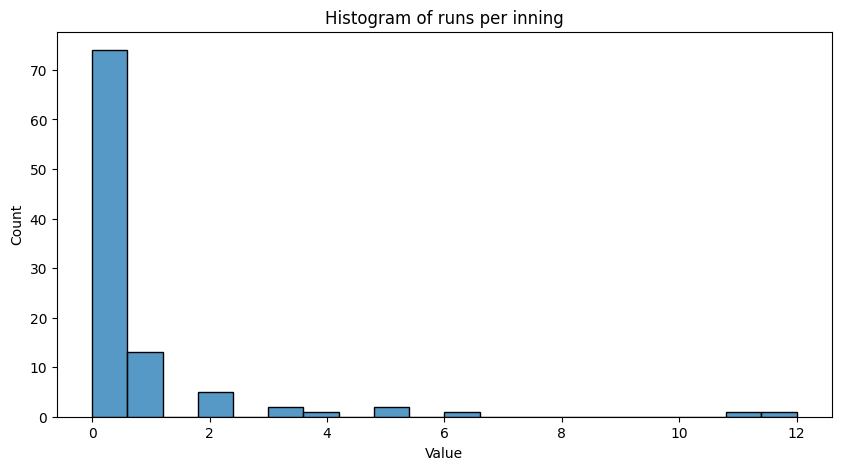

<Axes: xlabel='run_scored', ylabel='Count'>

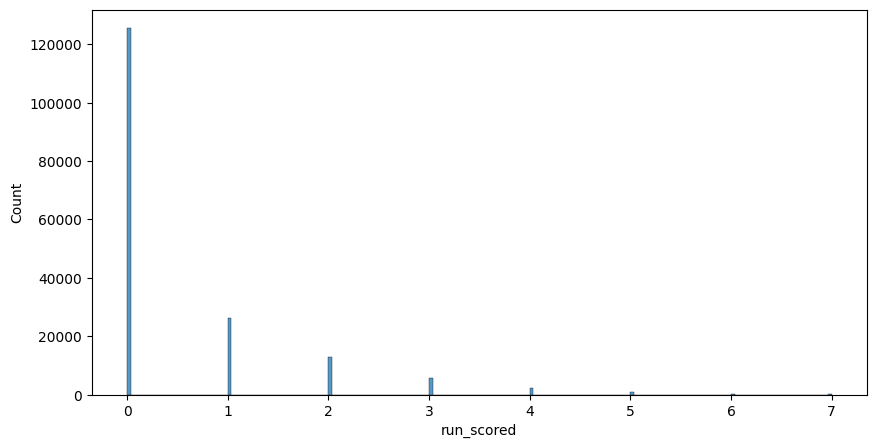

In [52]:
#plot distribution of runs scored per inning in simulation vs actual data

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=simulated)
plt.title("Histogram of runs per inning")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

sns.histplot(data=df["run_scored"])
